# Analyse en Classificatie van IDC-beelden

Dit notebook richt zich op het analyseren van IDC (Invasive Ductal Carcinoma) beelddata en het maken van eenconvolutioneel neuraal netwerk (CNN) voor de classificatie van IDC-negatieve en IDC-positieve beelden.

### Importeren van Bibliotheken

Het script begint met het importeren van vesrchillende Python-bibliotheken en modules die nodig zijn voor data-analyse, visualisatie, en modelontwikkeling:

- **`os`**: Voor het navigeren door en veranderen van de bestandssysteem.
- **`numpy`**: Een bibliotheek voor numerieke berekeningen en array-bewerkingen.
- **`pandas`**: het bekijken van data in de vorm van dataframes.
- **`matplotlib.pyplot`** en **`seaborn`**: Voor het maken van visualisaties.
- **`glob`**: Voor het zoeken naar bestanden.
- **`collections.defaultdict`**: Voor  werken met dictionaries die 
- **`sklearn.model_selection.train_test_split`**: Voor het splitsen van datasets in trainings- en testgroepen.
- **`tensorflow.keras`**: Voor het bouwen en trainen van deep learning-modellen, met lagen.
- **`sklearn.metrics`**: Voor het berekenen van classificatierapporten, verwarringsmatrices en ROC-curves.  
- **`ImagedataGenerator`**: Voor het scalen van de data en de data vergroten.




In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


### Lezen bestand

Hier word de data gelezen en uiteindelijk in een dataframe gezet met de juiste patient_id en label.

In [2]:

base_dir = "/students/2023-2024/Thema07/rumen_reactor/test/idc_regular"


data_info = defaultdict(list)

# Traverse the dataset
for patient_folder in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_folder)
    if os.path.isdir(patient_path):
        for label in ["0", "1"]: 
            label_path = os.path.join(patient_path, label)
            if os.path.exists(label_path):
                images = glob(os.path.join(label_path, "*.png"))
                data_info["patient_id"].extend([patient_folder] * len(images))
                data_info["label"].extend([int(label)] * len(images))
                data_info["file_path"].extend(images)


data_df = pd.DataFrame(data_info)

### analyse data 

Hieronder word de dataset samengevat onder de waardes staat alles uitgelegd.

In [3]:

print("Dataset Summary")
print("Total images:", len(data_df))
print(data_df["label"].value_counts(normalize=True) * 100)
print("\nSample rows from the dataset:")
print(data_df.head())

Dataset Summary
Total images: 277524
label
0    71.611104
1    28.388896
Name: proportion, dtype: float64

Sample rows from the dataset:
  patient_id  label                                          file_path
0       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
1       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
2       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
3       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...
4       9076      0  /students/2023-2024/Thema07/rumen_reactor/test...


### Dataset Samenvatting

Er zijn in totaal:
- **277.524 afbeeldingen**

De labelverdeling is:
| Label | Proportie (%) |
|-------|---------------|
| 0     | 71,61%        |
| 1     | 28,39%        |


- De dataset is **scheef verdeeld** (unbalanced dataset), waarbij label `0` de meerderheid vormt.
- **Label 0**: 71,61% van de dataset.
- **Label 1**: 28,39% van de dataset.

Mogelijke oplossingen
1. **Her-sampling**:
   - **Oversampling** van label `1` of **undersampling** van label `0`.
2. **Gebalanceerde gewichten**:
   - Gebruik klassen-gewichten tijdens modeltraining.



### Missing data

Hieronder word gekeken of er data mist.

In [17]:


print("Missing Data Check")
print(data_df.isnull().sum())

Missing Data Check
patient_id    0
label         0
file_path     0
x_coord       0
y_coord       0
dtype: int64


Zoals je hierboven ziet mist er geen data bij de patienten

### Figuur 1 

Hieronder word gekeken hoe de data verdeeld is zoals je ziet is er een ongelijke verdeling in de dataset.

/tmp/ipykernel_849946/3690410986.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=data_df, palette="Set2")


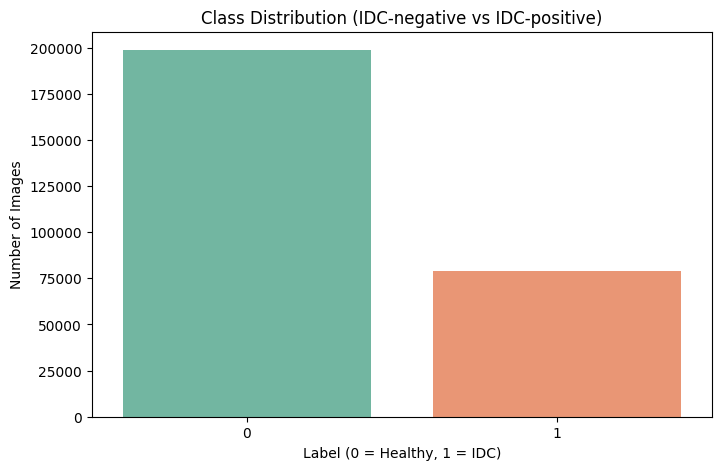

In [18]:

plt.figure(figsize=(8, 5))
sns.countplot(x="label", data=data_df, palette="Set2")
plt.title("Class Distribution (IDC-negative vs IDC-positive)")
plt.xlabel("Label (0 = Healthy, 1 = IDC)")
plt.ylabel("Number of Images")
plt.show()

### Figuur 3 

Hieronder wordt een analyse uitgevoerd op de dataset en visualiseert het percentage IDC-positieve beelden (Invasive Ductal Carcinoma) per patiënt met behulp van een boxplot. 

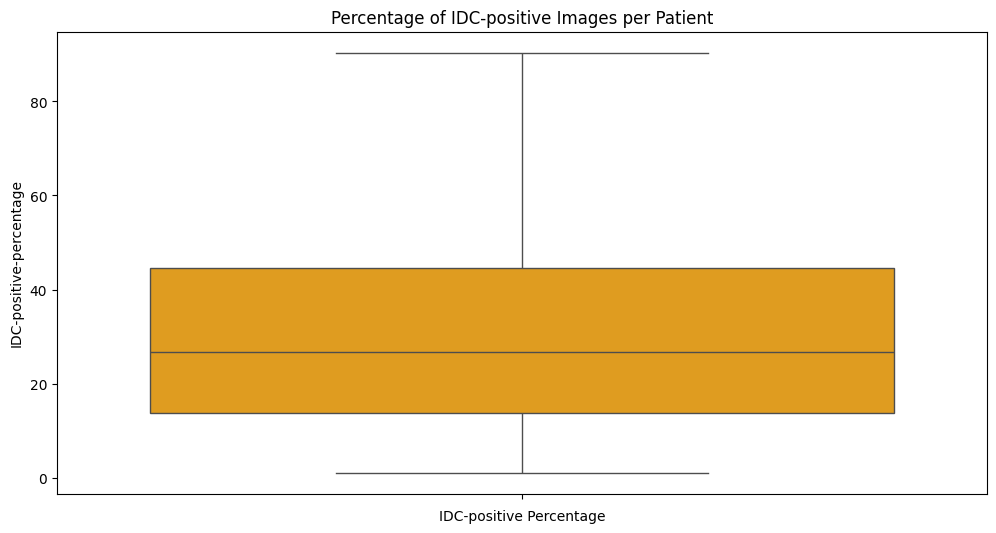

       IDC-negative  IDC-positive  IDC-positive-percentage
count    279.000000    279.000000               279.000000
mean       0.691934      0.308066                30.806634
std        0.201098      0.201098                20.109848
min        0.096491      0.010434                 1.043383
25%        0.553450      0.138298                13.829848
50%        0.733398      0.266602                26.660156
75%        0.861702      0.446550                44.655001
max        0.989566      0.903509                90.350877


In [19]:


patient_stats = data_df.groupby("patient_id")["label"].value_counts(normalize=True).unstack(fill_value=0)
patient_stats.columns = ["IDC-negative", "IDC-positive"]
patient_stats["IDC-positive-percentage"] = patient_stats["IDC-positive"] * 100

plt.figure(figsize=(12, 6))
sns.boxplot(patient_stats["IDC-positive-percentage"], color="orange")
plt.title("Percentage of IDC-positive Images per Patient")
plt.xlabel("IDC-positive Percentage")
plt.show()

print(patient_stats.describe())



### Uitleg van de statistieken

De tabel toont cijfers van de kolommen **IDC-negative**, **IDC-positive**, en **IDC-positive-percentage**. 

---

#### 1. **Kolommen**
- **IDC-negative**: Het gemiddelde aandeel van IDC-negatieve beelden per patiënt.
- **IDC-positive**: Het gemiddelde aandeel van IDC-positieve beelden per patiënt.
- **IDC-positive-percentage**: Het percentage IDC-positieve beelden (IDC-positive × 100).

---

#### 2. **Statistieken per rij**
- **count**: Het aantal patiënten (n = 279). Dit is gelijk voor alle kolommen omdat er geen ontbrekende waarden zijn.
- **mean**: Het gemiddelde van de waarden:
  - Gemiddeld zijn 69,19% van de beelden per patiënt IDC-negatief.
  - Gemiddeld zijn 30,81% van de beelden per patiënt IDC-positief.
- **std** (standaarddeviatie): De spreiding van de waarden:
  - De IDC-negative en IDC-positive percentages hebben een standaarddeviatie van ongeveer 20,11%.
  - Dit betekent dat de meeste waarden ongeveer 20,11% boven of onder het gemiddelde liggen.
- **min**: De laagste waarde:
  - Het laagste IDC-negative is 9,65%.
  - Het laagste IDC-positive is 1,04%.
- **25% (1e kwartiel)**: De ondergrens van de middelste 50% van de gegevens:
  - 25% van de patiënten heeft minder dan 55,34% IDC-negatieve beelden.
- **50% (mediaan)**: Het midden van de data:
  - Voor IDC-negative is dit 73,34% en voor IDC-positive 26,66%.
  - Dit betekent dat de helft van de patiënten meer dan 26,66% IDC-positieve beelden heeft.
- **75% (3e kwartiel)**: De bovengrens van de middelste 50% van de gegevens:
  - 75% van de patiënten heeft minder dan 86,17% IDC-negatieve beelden (of meer dan 44,66% IDC-positieve beelden).
- **max**: De hoogste waarde:
  - Het hoogste IDC-negative aandeel is 98,96%.
  - Het hoogste IDC-positive aandeel is 90,35% (of 90,35% in termen van percentage).

---

#### 3. **Wat zegt dit over de data?**
- **IDC-negative overheerst**: Gemiddeld heeft een patiënt meer IDC-negatieve beelden (69,19%) dan IDC-positieve beelden (30,81%).
- **Hoge spreiding**: De standaarddeviatie van 20,11% laat zien dat er veel variatie is in hoe IDC-positieve beelden verdeeld zijn per patiënt.
- **Uitschieters mogelijk**: Het verschil tussen de minimale waarde (1,04%) en de maximale waarde (90,35%) zegt dat er patiënten zijn met heel weinig of juist veel IDC-positieve beelden.


### commented code

Hieronder staat een code om de verdeling per patient te zien er zijn 279 patienten dus heel veel grafieken.
Je kunt het uncommenten om het te zien maar door de hoeveelheid is dat niet handiog voor de notebook.

In [ ]:


# patient_stats = data_df.groupby("patient_id")["label"].value_counts(normalize=True).unstack(fill_value=0)
# patient_stats.columns = ["IDC-negative", "IDC-positive"]
# patient_stats["IDC-positive-percentage"] = patient_stats["IDC-positive"] * 100


# for patient_id, stats in patient_stats.iterrows():
#     plt.figure(figsize=(6, 4))
#     plt.bar(["IDC-negative", "IDC-positive"], [stats["IDC-negative"], stats["IDC-positive"]], color=["blue", "orange"])
#     plt.title(f"IDC Label Verdeling voor Patiënt {patient_id}")
#     plt.ylabel("Percentage")
#     plt.xlabel("Label")
#     plt.ylim(0, 1)  
#     plt.show()

#     print(f"Patiënt {patient_id}:")
#     print(f"IDC-negative: {stats['IDC-negative']:.2%}, IDC-positive: {stats['IDC-positive']:.2%}\n")




### Analyze coordinaten

Hieronder worden de coordinaten opgeslagen en uit eindelijk geplot op basis welke het meest voor komt op die plek positief of negatieve IDC.

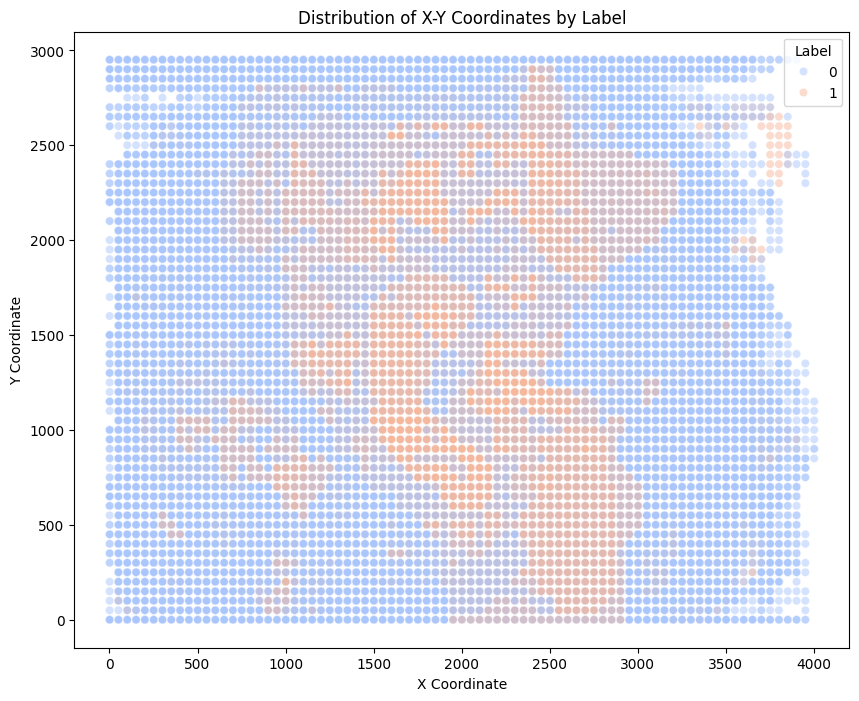

In [ ]:
def analyze_coordinates():
    
    def extract_coords(file_path):
            parts = os.path.basename(file_path).split("_")
            x_coord = int(parts[2][1:])  
            y_coord = int(parts[3][1:])  
            return x_coord, y_coord


    coords = data_df["file_path"].apply(extract_coords)
    data_df["x_coord"], data_df["y_coord"] = zip(*coords)


    data_df.dropna(subset=["x_coord", "y_coord"], inplace=True)


    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="x_coord", y="y_coord", hue="label",
        data=data_df, alpha=0.5, palette="coolwarm"
    )
    plt.title("Distribution of X-Y Coordinates by Label")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(title="Label", loc="upper right")
    plt.show()

analyze_coordinates()


### Figuur 3

Hierboven zie je dat de tumor het vaakst voorkomt volgens de plot langs de x coordinate 2000.   
Of dit iets is wat serieus genomen kan worden kan ik nog niet zeggen.

### code

hieronder worden een aantal voorbeelden van foto's van de dataset getoond.

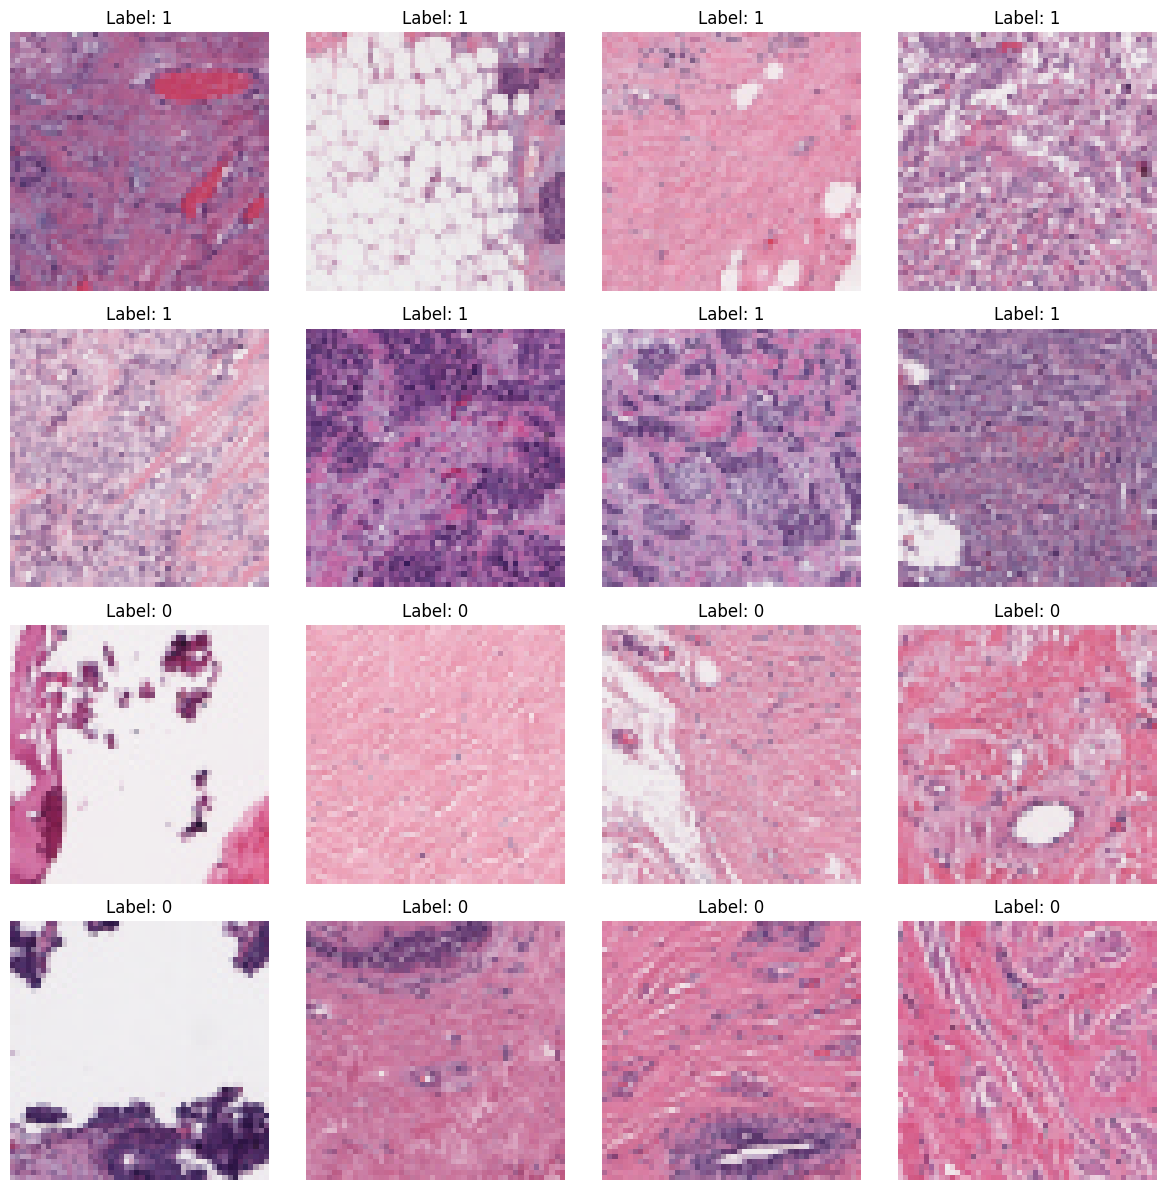

In [9]:

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
positive_samples = data_df[data_df["label"] == 1]["file_path"].sample(8).tolist()
negative_samples = data_df[data_df["label"] == 0]["file_path"].sample(8).tolist()
samples = positive_samples + negative_samples

for i, ax in enumerate(axes.flat):
    img = plt.imread(samples[i])
    label = 1 if i < 8 else 0
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.tight_layout()
plt.show()

Hier zie je 8 foto's van positieve en 8 foto's van negatieve afbeeldingen.
1 is positief.
0 is negtaief.

Hieronder word de code horizontaal gesplitst en in test en train datasets gezet. 

In [10]:

unique_patients = data_df["patient_id"].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

train_df = data_df[data_df["patient_id"].isin(train_patients)]
test_df = data_df[data_df["patient_id"].isin(test_patients)]

# Zorg ervoor dat labels strings zijn
train_df["label"] = train_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

print(f"Train patients: {len(train_patients)}, Test patients: {len(test_patients)}")
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")




Train patients: 223, Test patients: 56
Train samples: 218745, Test samples: 58779


/tmp/ipykernel_849946/2012594836.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/tmp/ipykernel_849946/2012594836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)


## Argumentatie voor Horizontale Splitsing


#### 1. **Generaliseerbaarheid naar Nieuwe Patiënten**
Bij **horizontale splitsing** worden de data verdeeld op basis van **patiënten**, wat betekent dat alle monsters van een specifieke patiënt in de trainingsset of de testset terechtkomen, maar niet in beide. Dit is belangrijk omdat we het model willen testen op **patiënten die het model nog niet heeft gezien**. 


#### 2. **Voorkomen van Overfitting**
Als je **verticaal splitst** (bijvoorbeeld door per monster te splitsen), kunnen er monsters van dezelfde patiënt zowel in de trainings- als de testset terechtkomen. Dit leidt tot het risico dat het model **patiëntspecifieke kenmerken** leert. 



#### 4. **Beperking van Data**
Hoewel horizontale splitsing de voorkeur heeft in de meeste gevallen, kan het ook een beperking zijn als je een kleine dataset hebt, omdat je dan mogelijk te weinig monsters hebt om zowel een representatieve trainings- als testset te creëren. Dit kan vooral problematisch zijn bij medische data, waar het aantal patiënten vaak beperkt is. Maar zelfs in dit geval is **horizontale splitsing** vaak nog steeds beter dan verticale splitsing, omdat het model dan getest wordt op een bredere variëteit aan patiënten in plaats van op een subset van dezelfde patiënten.




### Data Preprocessing en Generator Setup voor Beelddata

In het codeblok hierboven wordt een data-preprocessing en generator-setup uitgevoerd voor beelddata in een deep learning-project. Eerst worden twee `ImageDataGenerator`-instanties gecreëerd: `train_datagen` en `test_datagen`. De `train_datagen` is ingesteld om de afbeeldingen te schalen (rescale) en diverse augmentatietechnieken toe te passen, zoals rotatie, verschuiving (zowel horizontaal als verticaal) en horizontale flips. Dit helpt bij het vergroten van de variatie in de trainingsdata. De `test_datagen` schaling is eenvoudiger, enkel het schalen van de pixelwaardes (`1./255`) om de waarden tussen 0 en 1 te krijgen.

Daarna wordt de kolom `label` in zowel de trainings- als testdata omgezet naar het datatype string, wat nodig is voor verdere verwerking in het model.

Vervolgens worden twee generators (`train_generator` en `test_generator`) gemaakt met behulp van de `flow_from_dataframe`-methode. Deze generators laden de afbeeldingen vanuit de paden gespecificeerd in de DataFrame (`file_path`), passen de opgegeven transformaties toe, schalen de afbeeldingen naar 50x50 pixels, en categoriseren de beelden in een binair formaat (`class_mode="binary"`). De `batch_size` van 32 betekent dat elke batch van beelden 32 exemplaren bevat.

Kortom, deze code zorgt voor het voorbereiden van zowel de trainings- als testdata met schaalbewerking, augmentatie en het instellen van de juiste parameters voor de data-invoer in een neuraal netwerk.


In [11]:

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_df["label"] = train_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col="file_path", 
    y_col="label", 
    target_size=(50, 50), 
    class_mode="binary", 
    batch_size=32
)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col="file_path", 
    y_col="label", 
    target_size=(50, 50), 
    class_mode="binary", 
    batch_size=32
)



/tmp/ipykernel_849946/649981649.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["label"].astype(str)
/tmp/ipykernel_849946/649981649.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(str)


Found 218745 validated image filenames belonging to 2 classes.
Found 58779 validated image filenames belonging to 2 classes.


## Model Training 


1. **Conv2D(32, (3, 3), activation="relu", input_shape=(50, 50, 3))**:
   - De eerste laag is een 2D-convolutielaag met 32 filters van grootte 3x3.
   - De activatiefunctie is ReLU (Rectified Linear Unit).
   - De `input_shape` geeft aan dat de invoerafbeeldingen 50x50 pixels groot zijn en 3 kleurkanalen (RGB) bevatten.

2. **MaxPooling2D((2, 2))**:
   - Een max-poolinglaag met een poolgrootte van 2x2 wordt toegepast om de ruimtelijke dimensies van de feature map te verkleinen.

3. **Conv2D(64, (3, 3), activation="relu")**:
   - Een tweede convolutielaag met 64 filters van grootte 3x3 en de ReLU-activatiefunctie wordt toegevoegd.

4. **MaxPooling2D((2, 2))**:
   - Een tweede max-poolinglaag wordt toegepast om de dimensies verder te verkleinen.

5. **Flatten()**:
   - De `Flatten`-laag wordt gebruikt om de 2D-output van de laatste convolutielaag om te zetten naar een 1D-vector die geschikt is voor volledig verbonden lagen.

6. **Dense(128, activation="relu")**:
   - Een volledig verbonden laag met 128 neuronen en de ReLU-activatiefunctie wordt toegevoegd.

7. **Dropout(0.5)**:
   - Dropout wordt toegepast met een rate van 0.5, wat betekent dat 50% van de neuronen willekeurig worden uitgeschakeld tijdens de training om overfitting te voorkomen.

8. **Dense(1, activation="sigmoid")**:
   - De outputlaag heeft 1 neuron met de sigmoid-activatiefunctie, geschikt voor binaire classificatie (bijvoorbeeld classificatie van twee klassen).

Na het opbouwen van het model wordt het gecompileerd met de volgende instellingen:
- **Optimizer**: Adam, een  optimalisatiemethode.
- **Loss Function**: Binary Cross-Entropy, omdat het een binaire classificatie betreft.
- **Metrics**: Nauwkeurigheid (`accuracy`), om de prestaties van het model te evalueren tijdens de training en validatie.


In [12]:

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(50, 50, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


/homes/jrgommers/year 3/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-19 08:41:12.135904: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Model training

Hieronder wordt het model getraind nu staat die op 1 epoch aangezien de training nogal lang duurt maar dit kun je zelf verhogen.

In [13]:

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=1,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)


/homes/jrgommers/year 3/myenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6836/6836 ━━━━━━━━━━━━━━━━━━━━ 1080s 158ms/step - accuracy: 0.8104 - loss: 0.4359 - val_accuracy: 0.8432 - val_loss: 0.3705


Na de voortgangsinformatie worden de prestaties van het model weergegeven:

- **accuracy: 0.8104**: De nauwkeurigheid van het model op de trainingsdata is 81.04%.
- **loss: 0.4359**: Het verlies (loss) van het model op de trainingsdata is 0.4359. Een lager verlies geeft aan dat het model goed presteert.
- **val_accuracy: 0.8432**: De nauwkeurigheid van het model op de validatiedata is 84.32%, wat aangeeft hoe goed het model generaliseert naar nieuwe data.
- **val_loss: 0.3705**: Het verlies (loss) van het model op de validatiedata is 0.3705, wat eveneens aangeeft hoe goed het model presteert op onzichtbare data.

Samengevat geeft deze output inzicht in de prestaties van het model tijdens de training, zowel op de trainingsdata als op de validatiedata.


### Figure 4 

Hieronder wordt de code voor de confusion matrix en de roc curve gemaakt

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     44454
           1       0.24      0.26      0.25     14325

    accuracy                           0.62     58779
   macro avg       0.50      0.50      0.50     58779
weighted avg       0.63      0.62      0.63     58779



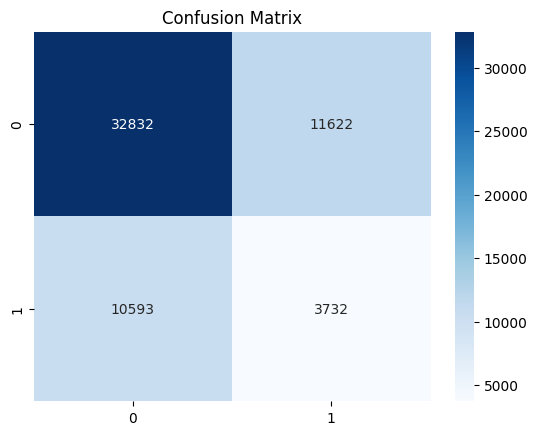

1837/1837 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step


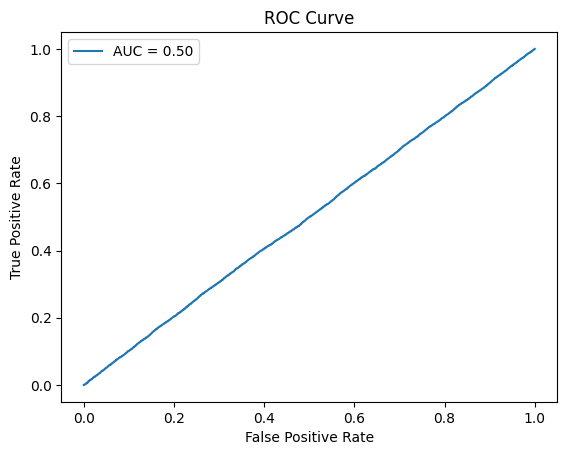

In [14]:

predictions = (model.predict(test_generator) > 0.5).astype(int)
true_labels = test_generator.classes

print("Classification Report")
print(classification_report(true_labels, predictions))

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(true_labels, model.predict(test_generator))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Analyse van de ROC Curve, Overfitting en Confusion Matrix

De **ROC curve** (Receiver Operating Characteristic curve) heeft een score van 50%, wat aangeeft dat het model niet beter presteert dan willekeurige classificatie. Dit kan wijzen op dat het model moeite heeft om onderscheid te maken tussen de positieve en negatieve klassen.

In de **Confusion Matrix** zien we lichte **overfitting**, wat betekent dat het model mogelijk goed presteert op de trainingsdata, maar niet zo goed generaliseert naar de testdata. Dit is te zien doordat het model goed presteert op de trainingsset, maar de prestaties op de testset (zoals aangegeven door de lagere nauwkeurigheid en hogere verlies) iets slechter zijn.

Deze lichte overfitting kan te maken hebben met een **scheve dataset**, waarin de negatieve data meer vertegenwoordigd is dan de positieve data. Wanneer de dataset ongebalanceerd is, kan het model geneigd zijn om de dominante klasse vaker correct te classificeren, wat leidt tot een verminderde prestatie bij het voorspellen van de positieve klasse.


